In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: No kernel provided, trying to apply Sobel(3, 3).


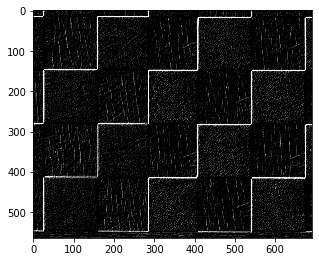

In [86]:
class ImageProcessing:
    def __init__(self):
        self.readmode = {1 : "RGB", 0 : "Grayscale"}
    
    def read_image(self, location = "", mode = 1):
        """
            Uses imageio on back.
            * location: Directory of image file.
            * mode: Image readmode{1 : RGB, 0 : Grayscale}.
        """
        
        img = imageio.imread(location)
        if mode == 1:
            img = img
        elif mode == 0:
            img = self.convert_color(img, 0)
        elif mode == 2:
            pass
        else:
            raise ValueError(f"Readmode not understood. Choose from {self.readmode}.")
        return img
    
    def show(self, image, figsize=(5, 5)):
        """
            Uses Matplotlib.pyplot.
            * image: A image to be shown.
            * figsize: How big image to show. From plt.figure()
            
        """
        fig = plt.figure(figsize=figsize)
        im = image
        plt.imshow(im, cmap='gray')
        plt.show()
    
    def convert_color(self, img, to=0):
        if to==0:
            return  0.21 * img[:,:,0] + 0.72 * img[:,:,1] + 0.07 * img[:,:,2]
        else:
            raise ValueError("Color conversion can not understood.")
    
    def convolve(self, image, kernel = None, padding = "zero", stride=(1, 1), show=False, bias = 0):
        """
            * image: A image to be convolved.
            * kernel: A filter/window of odd shape for convolution. Used Sobel(3, 3) default.
            * padding: Border operation. Available from zero, same, none. 
            * stride: How frequently do convolution? 
        """
        
        if len(image.shape) > 3:
            raise ValueError("Only 2 and 3 channel image supported.")
        if type(kernel) == type(None):
            warnings.warn("No kernel provided, trying to apply Sobel(3, 3).")
            kernel = np.array([[-1, 0, 1],
                              [-1, 0, 1],
                              [-1, 0, 1]])
            kernel += kernel.T
        kshape = kernel.shape
        if kshape[0] % 2 != 1 or kshape[1] % 2 != 1:
            raise ValueError("Please provide odd length of 2d kernel.")
        
        if type(stride) == int:
                 stride = (stride, stride)
        
        shape = image.shape
        #print(image.shape)
        """
            zeros_h = np.zeros((int(kshape[0]/2), shape[1])).reshape(-1, shape[1])
            zeros_v = np.zeros((int(kshape[1]/2), shape[0]+2*int(kshape[1]/2))).reshape(shape[0]+2*int(kshape[1]/2), -1)

            h1 = image[0].reshape(-1, shape[1])
            h1 = np.repeat(h1, int(kshape[0]/2)).reshape(-1, shape[1])
            h2 = image[-1].reshape(-1, shape[1])
            h2 = np.repeat(h2, int(kshape[0]/2)).reshape(-1, shape[1])


            #zero padding
            padded_img = np.vstack((h1, image, h2)) # add rows

            pshape = padded_img.shape
            v1 = padded_img[:, 0].reshape(pshape[0], -1)
            v1 = np.repeat(v1, int(kshape[1]/2)).reshape(pshape[0], -1)
            v2 = padded_img[:, -1].reshape(pshape[0], -1)
            v2 = np.repeat(v2, int(kshape[1]/2)).reshape(pshape[0], -1)
        """
        if padding == "zero":
            zeros_h = np.zeros(shape[1]).reshape(-1, shape[1])
            zeros_v = np.zeros(shape[0]+2).reshape(shape[0]+2, -1)

            #zero padding
            padded_img = np.vstack((zeros_h, image, zeros_h)) # add rows
            # print(padded_img)
            padded_img = np.hstack((zeros_v, padded_img, zeros_v)) # add cols

            image = padded_img
            shape = image.shape
            
        elif padding == "same":
            h1 = image[0].reshape(-1, shape[1])
            h2 = image[-1].reshape(-1, shape[1])


            #zero padding
            padded_img = np.vstack((h1, image, h2)) # add rows

            v1 = padded_img[:, 0].reshape(padded_img.shape[0], -1)
            v2 = padded_img[:, -1].reshape(padded_img.shape[0], -1)

            padded_img = np.hstack((v1, padded_img, v2)) # add cols

            image = padded_img
            shape = image.shape
        elif padding == None:
            pass

        rv = 0
        cimg = []
        for r in range(kshape[0], shape[0]+1, stride[0]):
            cv = 0
            for c in range(kshape[1], shape[1]+1, stride[1]):
                chunk = image[rv:r, cv:c]
                soma = (np.multiply(chunk, kernel)+bias).sum()
                try:
                    chunk = int(soma)
                except:
                    chunk = int(0)
                if chunk < 0:
                    chunk = 0
                if chunk > 255:
                    chunk = 255
                cimg.append(chunk)
                cv+=stride[1]
            rv+=stride[0]
        cimg = np.array(cimg, dtype=np.uint8).reshape(int(rv/stride[0]), int(cv/stride[1]))
        #print((r, c), (rv, cv))
        if show:
            print(f"Image convolved with \nKernel:{kernel}, \nPadding: {padding}, \nStride: {stride}")
        return cimg

ip = ImageProcessing()
img = ip.read_image("cb.jpg", mode=0)
#img = np.array([1, 10, 11, 200, 30, 12, 200, 152, 223, 60, 100, 
                #190, 11, 20, 10, 102, 207, 102, 223, 50, 18, 109, 117, 200, 30]).reshape(5, 5)
cv = ip.convolve(img)


ip.show(cv)


In [ ]:
# old FFL
class FFL():
    """
        A class to create a single input/hidden feedforward layer of given shape.
        
        Input:
        -------
        input_shape: Number of input values to layer. If none, tried to check from preious layer.
        neurons: Neurons on that layer.
        bias: External bias numpy array. If None, used from np.random.randn(neurons)
        weights: External weight numpy array. If None, used from np.random.randn(n_input, neurons)
        activation: One of ["relu", "sigmoid", "tanh", "softmax"].
        is_bias: Do we want bias to be used here? Default True.
        
        Output:
        --------
        Object of FFL which can be stacked later to use.
        
        Example:
        FFL(2, 2, activation="sigmoid")
    """
    
    def __init__(self, input_shape=None, neurons=1, bias=None, weights=None, activation=None, is_bias = True):
        
        np.random.seed(100)
        self.input_shape = input_shape
        self.neurons = neurons
        self.isbias = is_bias
        self.name = ""
        self.w = weights
        if input_shape != None:
            self.output_shape = neurons
        
        
        if self.input_shape != None:
            self.weights = weights if weights != None else np.random.randn(self.input_shape, neurons)
        if(is_bias):
            self.bias = bias if bias != None else np.random.randn(neurons)
        else:
            self.bias = 0
            
        self.out = None
        self.input = None
        self.error = None
        self.delta = None
        activations = ["relu", "sigmoid", "tanh", "softmax"]
        self.dw = 0
        self.db = 0
        if activation not in activations and activation != None:
             raise ValueError(f"Activation function not recognised. Use one of {activations} instead.")
        else:
            self.activation = activation
        self.parameters = np.multiply.reduce(self.weights.shape) + neurons if is_bias == True else 0
            
           
    def activation_dfn(self, r):
        """
            A method of FFL to find derivative of given activation function.
        """
        
        
        if self.activation is None:
            return np.ones(r.shape)
        
        if self.activation == "relu":
            r[r<0] = 0
            return r

        if self.activation == 'tanh':
            return 1 - r ** 2

        if self.activation == 'sigmoid':
            return r * (1 - r)

        if self.activation == "softmax":
            soft = self.activation_fn(r)
                    
            #s = soft.reshape(-1, 1)
            #dsoft = np.diagflat(s) - np.dot(s, s.T)
            #diag_soft = dsoft.diagonal()
            # take only the diagonal of dsoft i.e i==j only
            """
                soft = a / np.sum(a)

                dsoft = np.diag(soft)
                for i in range(len(x)):
                    for j in range(len(soft)):
                        if i == j:
                            d = 1
                        else:
                            d = 0
                        dsoft[i][j] = soft[i] * (d - soft[j])
            """
            diag_soft = soft * (1-soft)
            return diag_soft
        
        return r

    def activation_fn(self, r):
        """
        A method of FFL which contains the operation and defination of given activation function.
        """
        
        if self.activation == None or self.activation == "linear":
            return r
        if self.activation == "relu":
            r[r<0] = 0
            return r
        
        # tanh
        if self.activation == 'tanh':
            return np.tanh(r)

        # sigmoid
        if self.activation == 'sigmoid':
            
            return 1 / (1 + np.exp(-r))

        if self.activation == "softmax":
            # stable softmax
            r = r - np.max(r)
            s = np.exp(r)
            return s / np.sum(s)
        
    def apply_activation(self, x):
        soma = np.dot(x, self.weights) + self.bias
        self.out = self.activation_fn(soma)
        
        return self.out
    def set_n_input(self):
#         print(self.input_shape, self.neurons)
        self.weights = self.w if self.w != None else np.random.randn(int(self.input_shape), int(self.neurons))        
    def set_output_shape(self):
        self.set_n_input()
        self.get_parameters()
        self.output_shape = self.neurons
    def get_parameters(self):
        self.parameters = self.input_shape *  self.neurons + self.neurons if self.isbias else 0  
        return self.parameters


In [3]:
class Optimizer:
    def __init__(self, layers, name=None, learning_rate = 0.01, mr=0.001):
        self.name = name
        self.learning_rate = learning_rate
        self.mr = mr
        keys = ["sgd", "iterative", "momentum", "rmsprop", "adagrad", "adam", "adamax", "adadelta"]
        values = [self.sgd, self.iterative, self.momentum, self.rmsprop, self.adagrad, self.adam, self.adamax, self.adadelta]
        self.opt_dict = {keys[i]:values[i] for i in range(len(keys))}
        if name != None and name in keys:
            self.opt_dict[name](layers=layers, training=False)
            #pass
    def sgd(self, layers, learning_rate=0.01, beta=0.001, training=True):
        learning_rate = self.learning_rate
        for l in layers:
            if l.parameters !=0:
                if training:
                    l.weights += l.pdelta_weights*self.mr + l.delta_weights * learning_rate
                    l.biases += l.pdelta_biases*self.mr + l.delta_biases * learning_rate
                    l.pdelta_weights = l.delta_weights
                    l.pdelta_biases = l.delta_biases
                else:
                    l.pdelta_weights = 0
                    l.pdelta_biases = 0
                    #l.delta_weights = 0
                    #l.delta_biases = 0
    def iterative(self, layers, learning_rate=0.01, beta=0, training=True):
        for l in layers:
            if l.parameters !=0:
                l.weights -= learning_rate * l.delta_weights
                l.biases -= learning_rate * l.delta_biases
    def momentum(self, layers, learning_rate=0.1, beta1=0.9, weight_decay=0.0005, nesterov=True, training=True):
        learning_rate = self.learning_rate
        #beta1 = 1 - self.learning_rate
        for l in layers:
            if l.parameters !=0:
                if training:
                    l.weights_momentum = beta1 * l.weights_momentum + learning_rate * l.delta_weights-weight_decay *learning_rate*l.weights
                    l.weights+=l.weights_momentum
                    #
                    l.biases_momentum = beta1 * l.biases_momentum + learning_rate * l.delta_biases-weight_decay *learning_rate*l.biases
                    l.biases+=l.biases_momentum
                else:
                    l.weights_momentum = 0
                    l.biases_momentum = 0

            
    def rmsprop(self, layers, learning_rate=0.001, beta1=0.9, epsilon=1e-8, training=True):
        learning_rate=self.learning_rate
        for l in layers:
            if l.parameters !=0:
                if training:
                    l.weights_rms = beta1*l.weights_rms + (1-beta1)*(l.delta_weights ** 2)
                    l.weights += learning_rate * (l.delta_weights/np.sqrt(l.weights_rms + epsilon))
                    l.biases_rms = beta1*l.biases_rms + (1-beta1)*(l.delta_biases ** 2)
                    l.biases += learning_rate * (l.delta_biases/np.sqrt(l.biases_rms + epsilon))
                else:
                    l.weights_rms = 0
                    l.biases_rms = 0
    def adagrad(self, layers, learning_rate=0.01, beta1=0.9, epsilon=1e-8, training=True):
        learning_rate=self.learning_rate
        for l in layers:
            if l.parameters != 0:
                if training:
                    l.weights_adagrad += l.delta_weights ** 2
                    l.weights += learning_rate * (l.delta_weights/np.sqrt(l.weights_adagrad+epsilon))
                    l.biases_adagrad += l.delta_biases ** 2
                    l.biases += learning_rate * (l.delta_biases/np.sqrt(l.biases_adagrad+epsilon))
                else:
                    l.weights_adagrad = 0
                    l.biases_adagrad = 0
    def adam(self, layers, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, decay=0, training=True):
        #print(training)
        for l in layers:
            if l.parameters != 0:
                if training:
                    l.t += 1
                    if l.t == 1:
                        l.pdelta_biases = 0
                        l.pdelta_weights = 0
                    l.weights_adam1 = beta1 * l.weights_adam1 + (1-beta1)*l.delta_weights
                    l.weights_adam2 = beta2 * l.weights_adam2 + (1-beta2)*(l.delta_weights**2)
                    mcap = l.weights_adam1/(1-beta1**l.t)
                    vcap = l.weights_adam2/(1-beta2**l.t)
                    l.delta_weights = mcap/(np.sqrt(vcap) + epsilon)
                    l.weights += l.pdelta_weights * self.mr + learning_rate * l.delta_weights
                    l.pdelta_weights = l.delta_weights * 0

                    l.biases_adam1 = beta1 * l.biases_adam1 + (1-beta1)*l.delta_biases
                    l.biases_adam2 = beta2 * l.biases_adam2 + (1-beta2)*(l.delta_biases**2)
                    mcap = l.biases_adam1/(1-beta1**l.t)
                    vcap = l.biases_adam2/(1-beta2**l.t)
                    l.delta_biases = mcap/(np.sqrt(vcap) +epsilon)
                    l.biases += l.pdelta_biases * self.mr + learning_rate * l.delta_biases
                    l.pdelta_biases = l.delta_biases * 0
                    
                else:
                    l.t = 0
                    l.weights_adam1 = 0
                    l.weights_adam2 = 0
                    l.biases_adam1 = 0
                    l.biases_adam2 = 0
                    
    def adamax(self, layers, learning_rate=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8, training=True):
        for l in layers:
            if l.parameters != 0:
                if training:
                    l.weights_m = beta1*l.weights_m + (1-beta1)*l.delta_weights
                    l.weights_v = np.maximum(beta2*l.weights_v, abs(l.delta_weights))
                    l.weights += (self.learning_rate/(1-beta1))*(l.weights_m/(l.weights_v+epsilon))
                    
                    l.biases_m = beta1*l.biases_m + (1-beta1)*l.delta_biases
                    l.biases_v = np.maximum(beta2*l.biases_v, abs(l.delta_biases))
                    l.biases += (self.learning_rate/(1-beta1))*(l.biases_m/(l.biases_v+epsilon))
                    
                else:
                    l.weights_m = 0
                    l.biases_m = 0
                    l.weights_v = 0
                    l.biases_v = 0
                    
    def adadelta(self, layers, learning_rate=0.01, beta1=0.9, epsilon=1e-8, training=True):
        for l in layers:
            if l.parameters != 0:
                if training:
                    l.weights_v = beta1*l.weights_v + (1-beta1)*(l.delta_weights ** 2)
                    l.delta_weights = np.sqrt((l.weights_m+epsilon)/(l.weights_v+epsilon))*l.delta_weights
                    l.weights_m = beta1*l.weights_m + (1-beta1)*(l.delta_weights)
                    l.weights += l.delta_weights
                    
                    l.biases_v = beta1*l.biases_v + (1-beta1)*(l.delta_biases ** 2)
                    l.delta_biases = np.sqrt((l.biases_m+epsilon)/(l.biases_v+epsilon))*l.delta_biases
                    l.biases_m = beta1*l.biases_m+ (1-beta1)*(l.delta_biases)
                    l.biases += l.delta_biases
                    
                else:
                    l.weights_m = 0
                    l.biases_m = 0
                    l.weights_v = 0
                    l.biases_v = 0

In [4]:
# used on blogs
#from nn import NN, FFL
import time

class FFL():
    """
        A class to create a single input/hidden feedforward layer of given shape.
        
        Input:
        -------
        n_input: Number of input values to layer. If none, tried to check from preious layer.
        neurons: Neurons on that layer.
        bias: External bias numpy array. If None, used from np.random.randn(neurons)
        weights: External weight numpy array. If None, used from np.random.randn(n_input, neurons)
        activation: One of ["relu", "sigmoid", "tanh", "softmax"].
        is_bias: Do we want bias to be used here? Default True.
        
        Output:
        --------
        Object of FFL which can be stacked later to use.
        
        Example:
        FFL(2, 2, activation="sigmoid")
    """
    
    def __init__(self, input_shape=None, neurons=1, bias=None, weights=None, activation=None, is_bias = True):
        
        np.random.seed(100)
        self.input_shape = input_shape
        self.neurons = neurons
        self.isbias = is_bias
        self.name = ""
        
        
        self.w = weights
        self.b = bias
        if input_shape != None:
            self.output_shape = neurons
        
        
        if self.input_shape != None:
            self.weights = weights if weights != None else np.random.randn(self.input_shape, neurons)
            self.parameters = self.input_shape *  self.neurons + self.neurons if self.isbias else 0  
        if(is_bias):
            self.biases = bias if bias != None else np.random.randn(neurons)
        else:
            self.biases = 0
            
        self.out = None
        self.input = None
        self.error = None
        self.delta = None
        activations = ["relu", "sigmoid", "tanh", "softmax"]
        self.delta_weights = 0
        self.delta_biases = 0
        self.pdelta_weights = 0
        self.pdelta_biases = 0
        
        #self.bias = np.ones(self.bias.shape)
        
        if activation not in activations and activation != None:
             raise ValueError(f"Activation function not recognised. Use one of {activations} instead.")
        else:
            self.activation = activation
          
    def activation_dfn(self, r):
        """
            A method of FFL to find derivative of given activation function.
        """
        if self.activation == "relu":
            r[r<0] = 0
            return r
        
        if self.activation is None:
            return np.ones(r.shape)
        
        if self.activation == 'tanh':
            return 1 - r ** 2

        if self.activation == 'sigmoid':
            return r * (1 - r)

        if self.activation == "softmax":
            soft = self.activation_fn(r)
                    
            #s = soft.reshape(-1, 1)
            #dsoft = np.diagflat(s) - np.dot(s, s.T)
            #diag_soft = dsoft.diagonal()
            
            # take only the diagonal of dsoft i.e i==j only
            """
                soft = a / np.sum(a)

                dsoft = np.diag(soft)
                for i in range(len(x)):
                    for j in range(len(soft)):
                        if i == j:
                            d = 1
                        else:
                            d = 0
                        dsoft[i][j] = soft[i] * (d - soft[j])
            """
            diag_soft = soft*(1- soft)
            return diag_soft
        
        return r

    def activation_fn(self, r):
        """
        A method of FFL which contains the operation and defination of given activation function.
        """
        
        if self.activation == None or self.activation == "linear":
            return r

        # tanh
        if self.activation == 'tanh':
            return np.tanh(r)

        # sigmoid
        if self.activation == 'sigmoid':
            
            return 1 / (1 + np.exp(-r))

        if self.activation == "softmax":
            # stable softmax
            r = r - np.max(r)
            s = np.exp(r)
            return s / np.sum(s)
        if self.activation == "relu":
            r[r<0] = 0
            return r
        
    def apply_activation(self, x):
        soma = np.dot(x, self.weights) + self.biases
        self.out = self.activation_fn(soma)
        
        return self.out
    def set_n_input(self):
        self.weights = self.w if self.w != None else np.random.normal(size=(self.input_shape, self.neurons))
    def backpropagate(self, nx_layer):
        self.error = np.dot(nx_layer.weights, nx_layer.delta)
        self.delta = self.error * self.activation_dfn(self.out)
        self.delta_weights += self.delta * np.atleast_2d(self.input).T
        self.delta_biases += self.delta
    
    # added below methods from cnn
    def set_output_shape(self):
        self.set_n_input()
        self.output_shape = self.neurons
        self.get_parameters()
    def get_parameters(self):
        self.parameters = self.input_shape *  self.neurons + self.neurons if self.isbias else 0  
        return self.parameters

class Dropout:
    def __init__(self, prob = 0.5):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        self.prob = prob
        self.delta_weights = 0
        self.delta_biases = 0
        
        
    def set_output_shape(self):
        #print(self.input_shape)
        self.output_shape = self.input_shape
        self.weights = 0
    def apply_activation(self, x, train=True):
        if train:
            self.input_data = x
            #print(x.sum(axis=2))
            flat = np.array(self.input_data).flatten()
            random_indices = np.random.randint(0, len(flat), int(self.prob * len(flat)))
            flat[random_indices] = 0
            self.output = flat.reshape(x.shape)
            return self.output
        else:
            self.input_data = x
            self.output = x / self.prob
            return self.output
    def activation_dfn(self, x):
        return x
    def backpropagate(self, nx_layer):
        if type(nx_layer).__name__ != "Conv2d":
            self.error = np.dot(nx_layer.weights, nx_layer.delta)
            self.delta = self.error * self.activation_dfn(self.out)
        else:
            self.delta = nx_layer.delta
        self.delta[self.output == 0] = 0
def one_hot_encoding(lbl, classes):
    encoded = np.zeros((len(lbl), classes))
    c = list(set(lbl))
    if len(c) != classes:
        raise ValueError("Number of classes is not equal to unique labels.")
    for i in range(len(yy)):
        for j in range(len(c)):
            if c[j] == lbl[i]:
                encoded[i, j] = 1
    return encoded
class Upsample:
    def __init__(self, kernel_size = (2, 2)):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        self.delta_weights = 0
        self.delta_biases = 0        
        self.kernel_size = kernel_size
        self.stride = self.kernel_size
        
    
    def set_output_shape(self):
        shape = self.input_shape
        self.output_shape = (shape[0] * self.kernel_size[0], shape[1] * self.kernel_size[1], shape[2])
        self.weights = 0
    def apply_activation(self, image):
        stride = self.stride
        kshape = self.kernel_size
        self.input_shape = image.shape
        self.set_output_shape()
        
        rstep = stride[0]
        cstep = stride[1]
        self.out = np.zeros(self.output_shape)
        shape = self.output_shape
        
        
        for nc in range(shape[2]):
            cimg = []
            rv = 0
            i = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    self.out[rv:r, cv:c] = image[i, j]
                    j+=1
                    cv+=cstep
                rv+=rstep
                i+=1
                
        return self.out
    def backpropagate(self, nx_layer):
        """
            Gradients are passed through index of largest value .
        """
        layer = self
        stride = layer.stride
        kshape = layer.kernel_size
        image = layer.input
        shape = image.shape
        layer.delta = np.zeros(shape)
        
        cimg = []
        rstep = stride[0]
        cstep = stride[1]
        shape = nx_layer.delta.shape
        for f in range(shape[2]):
            i = 0
            rv = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    dout = nx_layer.delta[rv:r, cv:c, f]
                    layer.delta[i, j, f] = dout


                    j+=1
                    cv+=cstep
                rv+=rstep
                i+=1
            
class Pool2d:
    def __init__(self, kernel_size = (2, 2), stride=None, kind="max", padding=None):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        self.delta_weights = 0
        self.delta_biases = 0
        self.padding = padding
        self.p = 1 if padding != None else 0
        self.kernel_size = kernel_size
        if type(stride) == int:
                 stride = (stride, stride)

        self.stride = stride
        if self.stride == None:
            self.stride = self.kernel_size
        self.pools = ['max', "average", 'min']
        if kind not in self.pools:
            raise ValueError("Pool kind not understoood.")
            
        self.kind = kind
    
    def set_output_shape(self):
        shape = self.input_shape
        self.output_shape = (int((self.input_shape[0] - self.kernel_size[0] + 2 * self.p) / self.stride[0] + 1), 
                                int((self.input_shape[1] - self.kernel_size[1] + 2 * self.p) / self.stride[1] + 1), self.input_shape[2])
        
#         stride = self.stride
#         kshape = self.kernel_size
#         rstep = stride[0]+kshape[0]-1
#         cstep = stride[1]+kshape[1]-1
#         rv = rstep * len(range(kshape[0], shape[0]+1, rstep))
#         cv = cstep * len(range(kshape[1], shape[1]+1, cstep))
#         self.output_shape = (int(rv/rstep), int(cv/cstep), shape[2])
#         print(self.output_shape)
        self.weights = 0
    def apply_activation(self, image):
        stride = self.stride
        kshape = self.kernel_size
        shape = image.shape
        self.input_shape = shape
        self.set_output_shape()
        #print(self.output_shape, shape)
        
        
        rstep = stride[0]+kshape[0]-1
        cstep = stride[1]+kshape[1]-1
        self.out = np.zeros((self.output_shape))
        for nc in range(shape[2]):
            cimg = []
            rv = 0
            for r in range(kshape[0], shape[0]+1, stride[0]):
                cv = 0
                for c in range(kshape[1], shape[1]+1, stride[1]):
                    chunk = image[rv:r, cv:c, nc]
                    if len(chunk) > 0:
                        
                        if self.kind == "max":
                            #print(chunk)
                            chunk = np.max(chunk)
                        if self.kind == "min":
                            chunk = np.min(chunk)
                        if self.kind == "average":
                            chunk = np.mean(chunk)

                        cimg.append(chunk)
                    else:
                        cv-=cstep
                        #rv-=rstep
                    cv+=stride[1]
                rv+=stride[0]
            cimg = np.array(cimg).reshape(int(rv/stride[0]), int(cv/stride[1]))
            #print(cimg.shape)
            self.out[:,:,nc] = cimg
        return self.out
    def backpropagate(self, nx_layer):
        """
            Gradients are passed through index of largest value .
        """
        layer = self
        stride = layer.stride
        kshape = layer.kernel_size
        image = layer.input
        shape = image.shape
        layer.delta = np.zeros(shape)
        #self.input_shape = shape
        #self.set_output_shape()
        #print(self.output_shape)
        
        cimg = []
        rstep = stride[0]
        cstep = stride[1]
        
        for f in range(shape[2]):
            i = 0
            rv = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    chunk = image[rv:r, cv:c, f]
                    dout = nx_layer.delta[i, j, f]
                    
                    if layer.kind == "max":
                        p = np.max(chunk)
                        #print(p, chunk)
                        index = np.argwhere(chunk == p)[0]
                        #print(layer.delta[rv+index[0], cv+index[1], f].shape, dout.shape)
                        layer.delta[rv+index[0], cv+index[1], f] = dout
                        #print(index)
                    if layer.kind == "min":
                        p = np.min(chunk)
                        index = np.argwhere(chunk == p)[0]
                        layer.delta[rv+index[0], cv+index[1], f] = dout
                    if layer.kind == "average":
                        p = np.mean(chunk)
                        layer.delta[rv:r, cv:c, f] = dout


                    j+=1
                    cv+=cstep
                rv+=rstep
                i+=1
            
class Flatten:
    def __init__(self, input_shape=None):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        self.delta_weights = 0
        self.delta_biases = 0
        
    def set_output_shape(self):
        #print(self.input_shape)
        self.output_shape = (self.input_shape[0] * self.input_shape[1] * self.input_shape[2])
        self.weights = 0
    def apply_activation(self, x):
        self.input_data = x
        #print(x.sum(axis=2))
        self.output = np.array(self.input_data).flatten()
        return self.output
    def activation_dfn(self, x):
        return x
    def backpropagate(self, nx_layer):
        self.error = np.dot(nx_layer.weights, nx_layer.delta)
        self.delta = self.error * self.activation_dfn(self.out)
        self.delta = self.delta.reshape(self.input_shape)

class Conv2d():
    def __init__(self, input_shape=None, filters=1, kernel_size = (3, 3), isbias=True, activation=None, stride=(1, 1), padding="zero", kernel=None, bias=None):
        #super().__init__()
        self.input_shape = input_shape
        self.filters = filters
        self.isbias = isbias
        self.activation = activation
        self.stride = stride
        self.padding = padding
        self.p = 1 if padding != None else 0
        self.bias = bias
        self.kernel = kernel
        if input_shape != None:
            # (h, w, nc, nf)
            self.kernel_size = (kernel_size[0], kernel_size[1], input_shape[2], filters)
            self.output_shape = (int((input_shape[0] - kernel_size[0] + 2 * self.p) / stride[0]) + 1, 
                                int((input_shape[1] - kernel_size[1] + 2 * self.p) / stride[1]) + 1, filters)
            self.set_variables()
            self.out = np.zeros(self.output_shape)
            self.dout = np.zeros((self.output_shape[0], self.output_shape[1], self.input_shape[2], self.output_shape[2]))
        else:
            #pass
            # we dont know input shape yet
            self.kernel_size = (kernel_size[0], kernel_size[1])
            #self.set_variables()
            
        self.delta = 0
        self.dfilt = 0
        self.dbias = 0
        self.error = 0
        #self.out = np.zeros(self.output_shape)
        #self.dout = np.zeros(self.output_shape)
        self.flow = None
        
        # make suitable for all layers
        #self.weights = self.kernel
        #self.biases = self.bias
        
    def init_param(self, size):
        stddev = 1/np.sqrt(np.prod(size))
        return np.random.normal(loc=0, scale=stddev, size=size)
    def set_variables(self):
        """
        self.bias = np.random.random((self.filters, 1))
        #self.bias = np.random.random((self.kernel_size[0], self.kernel_size[1], self.input_shape[2], self.filters)) if self.isbias == True and self.bias==None else 0
        self.kernel = np.random.random((self.kernel_size[0], self.kernel_size[1], self.input_shape[2], self.filters)) if self.kernel == None else self.kernel
        self.parameters = np.multiply.reduce(self.kernel_size) * 2 if self.isbias else 1        
        self.d_final_filt = np.zeros(self.kernel.shape)
        self.d_final_bias = np.zeros(self.bias.shape)
        self.kernel = self.init_param(self.kernel.shape)
        """
        self.weights = self.init_param(self.kernel_size)
        self.biases = self.init_param((self.filters, 1))
        self.parameters = np.multiply.reduce(self.kernel_size) + self.filters if self.isbias else 1
        self.delta_weights = np.zeros(self.kernel_size)
        self.delta_biases = np.zeros(self.biases.shape)
        #print(self.weights.shape, self.biases.shape)
       
    def apply_activation(self, image):
        #print(self.weights, self.biases)
        for f in range(self.filters):
            image = self.input
            kshape = self.kernel_size
            if kshape[0] % 2 != 1 or kshape[1] % 2 != 1:
                raise ValueError("Please provide odd length of 2d kernel.")

            if type(self.stride) == int:
                     stride = (stride, stride)
            else:
                stride = self.stride
            shape = image.shape
            if self.padding == "zero":
                zeros_h = np.zeros((shape[1], shape[2])).reshape(-1, shape[1], shape[2])
                zeros_v = np.zeros((shape[0]+2, shape[2])).reshape(shape[0]+2, -1, shape[2])
                #print(image.shape, zeros_h.shape, zeros_v.shape)
                #zero padding
                padded_img = np.vstack((zeros_h, image, zeros_h)) # add rows
                # print(padded_img)
                padded_img = np.hstack((zeros_v, padded_img, zeros_v)) # add cols

                image = padded_img
                shape = image.shape

            elif self.padding == "same":
                h1 = image[0].reshape(-1, shape[1], shape[2])
                h2 = image[-1].reshape(-1, shape[1], shape[2])


                #zero padding
                padded_img = np.vstack((h1, image, h2)) # add rows

                v1 = padded_img[:, 0].reshape(padded_img.shape[0], -1, shape[2])
                v2 = padded_img[:, -1].reshape(padded_img.shape[0], -1, shape[2])

                padded_img = np.hstack((v1, padded_img, v2)) # add cols

                image = padded_img
                shape = image.shape
            elif self.padding == None:
                pass

            rv = 0
            cimg = []
            for r in range(kshape[0], shape[0]+1, stride[0]):
                cv = 0
                for c in range(kshape[1], shape[1]+1, stride[1]):
                    #if r - rv
                    chunk = image[rv:r, cv:c]
                    #print(chunk.shape, self.kernel[:, :, :, f].shape)
                    # soma with each input image's chunk(can have channel) * kernel(can have channels)
                    soma = (np.multiply(chunk, self.weights[:, :, :, f]))
                    summa = soma.sum()+self.biases[f]
                    #print(soma.shape)
                    #summa = soma.mean()
                    #print(f"soma{soma.shape} \n chunk{chunk.shape}, {summa.shape}")
                    
                    cimg.append(summa)
                    cv+=stride[1]
                rv+=stride[0]
            #print((r, c), (rv, cv))
            cimg = np.array(cimg).reshape(int(rv/stride[0]), int(cv/stride[1]))
            #print(cimg.shape)
            self.out[:, :, f] = cimg
        self.out = self.activation_fn(self.out)
        return self.out
        
    
    def activation_dfn(self, r):
        """
            A method of FFL to find derivative of given activation function.
        """
        
        
        if self.activation is None:
            return np.ones(r.shape)

        if self.activation == 'tanh':
            return 1 - r ** 2
        if self.activation == "relu":
            r[r<0] = 0
            return r
        if self.activation == 'sigmoid':
            return r * (1 - r)

        if self.activation == "softmax":
            soft = self.activation_fn(r)
            diag_soft = soft * (1-soft)        
            #s = soft.reshape(-1, 1)
            #dsoft = np.diagflat(s) - np.dot(s, s.T)
            #diag_soft = dsoft.diagonal()
            # take only the diagonal of dsoft i.e i==j only
            """
                soft = a / np.sum(a)

                dsoft = np.diag(soft)
                for i in range(len(x)):
                    for j in range(len(soft)):
                        if i == j:
                            d = 1
                        else:
                            d = 0
                        dsoft[i][j] = soft[i] * (d - soft[j])
            """
            
            return diag_soft
        
        return r
    
    def activation_fn(self, r):
        """
        A method of FFL which contains the operation and defination of given activation function.
        """
        
        if self.activation == None or self.activation == "linear":
            return r
        if self.activation == "relu":
            r[r<0] = 0
            return r
        
        # tanh
        if self.activation == 'tanh':
            return np.tanh(r)

        # sigmoid
        if self.activation == 'sigmoid':
            
            return 1 / (1 + np.exp(-r))

        if self.activation == "softmax":
            # stable softmax
            r = r - np.max(r)
            s = np.exp(r)
            return s / np.sum(s)
        
    def set_output_shape(self):
        #print(self.input_shape, self.kernel_size, self.stride)
        self.kernel_size = (self.kernel_size[0], self.kernel_size[1], self.input_shape[2], self.filters)
        self.set_variables()
        self.output_shape = (int((self.input_shape[0] - self.kernel_size[0] + 2 * self.p) / self.stride[0] + 1), 
                                int((self.input_shape[1] - self.kernel_size[1] + 2 * self.p) / self.stride[1] + 1), self.filters)
        self.out = np.zeros(self.output_shape)
        self.dout = np.zeros((self.output_shape[0], self.output_shape[1], self.input_shape[2], self.output_shape[2]))
    
    def backpropagate(self, nx_layer):
        layer = self
        #layer.dfilt = np.zeros(layer.kernel.shape)
        #layer.delta = np.zeros(layer.input_shape)
        #layer.dbias = np.zeros(layer.bias.shape)
        layer.delta = np.zeros((layer.input_shape[0], layer.input_shape[1], layer.input_shape[2]))
        
        image = layer.input
        #print(layer.name, layer.delta.shape)
        #print(f"nx lyr's delshape", nx_layer.delta.shape, layer.input_shape)
        #print(f"{nx_layer.delta.shape, layer.kernel.shape}")
         
        for f in range(layer.filters):
            kshape = layer.kernel_size
            shape = layer.input_shape
            stride = layer.stride
            rv = 0
            i = 0
            #print(layer.kernel.shape)
            for r in range(kshape[0], shape[0]+1, stride[0]):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, stride[1]):
                    chunk = image[rv:r, cv:c]
                    #print(layer.name, chunk.shape, layer.dfilt.shape, nx_layer.delta.shape)
                    #"""
                    #original
                    #print(layer.delta_weights.shape)
                    layer.delta_weights[:, :, :, f] += chunk * nx_layer.delta[i, j, f]
                    
                    #layer.delta[rv:r, cv:c] += nx_layer.delta[i, j] * layer.dfilt[f]
                    #print("upd", layer.delta[rv:r, cv:c, f].shape, nx_layer.delta[i, j, f].shape, layer.kernel[:, :, :, f].shape)
                    #print(layer.name, layer.kernel.shape)
                    layer.delta[rv:r, cv:c, :] += nx_layer.delta[i, j, f] * layer.weights[:, :, :, f]
                    #chunk = int((np.multiply(chunk, kernel)+bias).sum())
                    j+=1
                    cv+=stride[1]
                rv+=stride[0]
                i+=1
            #layer.kernel[f] += dfilt
            layer.delta_biases[f] = np.sum(nx_layer.delta[:, :, f])
        layer.delta = layer.activation_dfn(layer.delta)
        

"""New CNN."""        
class CNN():
    def __init__(self):
        self.layers = []
        self.info_df = {}
        self.column = ["LName", "Input Shape", "Output Shape", "Activation", "Bias"]
        self.parameters = []
        self.optimizer = ""
        self.loss = "mse"
        #self.all_loss = {}
        self.lr = 0.01
        self.mr = 0.0001
        self.metrics = []
        self.av_optimizers = ["sgd", "momentum", "adam"]
        self.av_metrics = ["mse", "accuracy", "cse"]
        self.av_loss = ["mse", "cse"]
        self.iscompiled = False
        self.model_dict = None
        self.out = []
        self.eps = 1e-15
        #self.non_trainable=["Flatten"]
        self.train_loss = {}
        self.val_loss = {}
        self.train_acc = {}
        self.val_acc = {}
    
    def add(self, layer):
        if(len(self.layers) > 0):
            prev_layer = self.layers[-1]
            if prev_layer.name != "Input Layer":
                prev_layer.name = f"{type(prev_layer).__name__}{len(self.layers) - 1}" 
            
            if layer.input_shape == None:
                if type(layer).__name__ == "Flatten":
                        ops = prev_layer.output_shape[:]
                        if type(prev_layer).__name__ == "Pool2d":
                            ops = prev_layer.output_shape[:]
                elif type(layer).__name__ == "Conv2d":
                    ops = prev_layer.output_shape[:]
                    if type(prev_layer).__name__ == "Pool2d":
                        ops = prev_layer.output_shape
                elif type(layer).__name__ == "Pool2d":
                    ops = prev_layer.output_shape[:]
                    if type(prev_layer).__name__ == "Pool2d":
                        ops = prev_layer.output_shape[:]
                    #print(prev_layer.output_shape)
                    
                else:
                    ops = prev_layer.output_shape
                layer.input_shape = ops
#                 print(prev_layer.output_shape)
                #print(type(layer).__name__, layer.input_shape)
                layer.set_output_shape()
            layer.name = f"Out Layer({type(layer).__name__})"
            #if prev_layer.neurons != layer.n_input:
             #   raise ValueError(f"This layer '{layer.name}' must have neurons={prev_layer.neurons} because '{prev_layer.name}' has output of {prev_layer.neurons}.")
        else:
            layer.name = "Input Layer"
        if type(layer).__name__ == "Conv2d":
            if(layer.output_shape[0] <= 0 or layer.output_shape[1] <= 0):
                raise ValueError(f"The output shape became invalid [i.e. {layer.output_shape}]. Reduce filter size or increase image size.")
        self.layers.append(layer)
        self.parameters.append(layer.parameters)
        
    def summary(self):
        lname = []
        linput = []
        loutput = []
        lactivation = []
        lisbias = []
        lparam = []
        for layer in self.layers:
            lname.append(layer.name)
            linput.append(layer.input_shape)
            loutput.append(layer.output_shape)########################
            lactivation.append(layer.activation)
            lisbias.append(layer.isbias)
            lparam.append(layer.parameters)
        model_dict = {"Layer Name": lname, "Input": linput, "Output Shape": loutput,
                      "Activation": lactivation, "Bias": lisbias, "Parameters": lparam}    
        model_df = pd.DataFrame(model_dict).set_index("Layer Name")
        print(model_df)
        print(f"Total Parameters: {sum(lparam)}")
    
    def apply_loss(self, y, out):
        if self.loss == "mse":
            #print(output_shape)
            loss = y - out
            mse = np.mean(np.square(loss), axis=-1)
#             self.all_loss.append(mse)          
            return loss, mse

        if self.loss == 'cse':
            """ Requires out to be probability values. """     
            if len(out) == len(y) == 1:
                #print("Using Binary CSE.")
                #y += self.eps
                #out += self.eps
                cse = -(y * np.log(out) + (1 - y) * np.log(1 - out))
                loss = -(y / out - (1 - y) / (1 - out))
                #cse = np.mean(abs(cse))
            else:
                #print("Using Categorical CSE.")
                if self.layers[-1].activation == "softmax":
                    # if o/p layer's fxn is softmax then loss is y - out
                    # check the derivation of softmax and crossentropy with derivative
                    loss = y - out
                    loss = loss / self.layers[-1].activation_dfn(out)
                else:
                    y = np.float64(y)
                    #y += self.eps
                    out += self.eps
                    #cse =  -np.sum(y * (np.log(out)))
                    
                    loss = -(np.nan_to_num(y / out, posinf=0, neginf=0) - np.nan_to_num((1 - y) / (1 - out), posinf=0, neginf=0))
                
            
                cse = -np.sum(y * np.nan_to_num(np.log(out), posinf=0, neginf=0) + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=0, neginf=0))
            return loss, cse
    
    def compile_model(self, lr=0.01, mr = 0.001, opt = "sgd", loss = "mse", metrics=['mse']):
        if opt not in self.av_optimizers:
            raise ValueError(f"Optimizer is not understood, use one of {self.av_optimizers}.")
        
        for m in metrics:
            if m not in self.av_metrics:
                raise ValueError(f"Metrics is not understood, use one of {self.av_metrics}.")
        
        if loss not in self.av_loss:
            raise ValueError(f"Loss function is not understood, use one of {self.av_loss}.")
        
        self.optimizer = opt
        self.loss = loss
        self.lr = lr
        self.mr = mr
        self.metrics = metrics
        self.iscompiled = True
        self.optimizer = Optimizer(layers=self.layers, name=opt, learning_rate=lr, mr=mr)
        self.optimizer = self.optimizer.opt_dict[opt]
        """
            if opt == "sgd":
                self.optimizer = self.SGD
            elif opt == "adam":
                self.optimizer = self.ADAM
                alpha = self.lr
                beta1 = 0.9
                beta2 = 0.999
                epsilon = 1e-8
                for l in self.layers:
                    if type(l).__name__ == "FFL":
                        l.adam_param = []
                        l.dprev = [0]
                        # w, a, b1, b2, eps, m, v, t
                        l.adam_param = [[l.weights, alpha, beta1, beta2, epsilon, 0, 0, 0]]
                        if l.isbias:
                            l.adam_param.append([l.bias, alpha, beta1, beta2, epsilon, 0, 0, 0])
                            l.dprev.append(0)
                    if type(l).__name__ == "Conv2d":
                        l.adam_param = []
                        l.dprev = [0]
                        l.adam_param = [[l.kernel, alpha, beta1, beta2, epsilon, 0, 0, 0]]
                        if l.isbias:
                            l.adam_param.append([l.bias, alpha, beta1, beta2, epsilon, 0, 0, 0])
                            l.dprev.append(0)
        """
    def SGD(self, update):
        for i in range(len(self.layers)):    
            layer = self.layers[i]
            
            if type(layer).__name__ == "FFL":
                input_to_use = np.atleast_2d(layer.input)
                dw = layer.delta * input_to_use.T 
                db =  layer.delta 
                if update:
                    layer.weights += (layer.dw * self.mr / self.batch_size + dw * self.lr)
                    layer.bias += (layer.db * self.mr / self.batch_size +  db * self.lr)
                    layer.dw = 0
                    layer.db = 0
                else:
                    layer.dw += dw 
                    layer.db += db 
            if type(layer).__name__ == "Conv2d":
                if update != True:
                    layer.kernel += (layer.d_final_filt * self.mr/ self.batch_size + layer.dfilt * self.lr)
                    layer.bias += (layer.d_final_bias * self.mr/ self.batch_size + layer.dbias * self.lr)
                    layer.d_final_filt = 0
                    layer.d_final_bias = 0
                else:
                    layer.d_final_filt += layer.dfilt 
                    layer.d_final_bias += layer.dbias 
                
    def ADAM(self, update):
        
        for i in range(len(self.layers)):
            layer = self.layers[i]       
            if type(layer).__name__ == "FFL":
                input_to_use = np.atleast_2d(layer.input)
                dw = layer.delta * input_to_use.T 
                db =  layer.delta 
                dparam = [dw, db]
                nparam = []
                l = layer
                for i, grad in enumerate(dparam):
                    #print(i)
                    theta = l.adam_param[i][0]
                    alpha = l.adam_param[i][1]
                    beta1 = l.adam_param[i][2]
                    beta2 = l.adam_param[i][3]
                    epsilon = l.adam_param[i][4]
                    m = l.adam_param[i][5]
                    v = l.adam_param[i][6]
                    t = l.adam_param[i][7] + 1

                    m = beta1 * m + (1-beta1) * grad # moving avg of grad
                    v = beta2 * v + (1-beta2) * np.power(grad, 2) #
                    m_cap = m / (1 - np.power(beta1, t))
                    v_cap = v / (1 - np.power(beta2, t))
                    theta += (self.mr * layer.dprev[i]) + np.nan_to_num(alpha * (m_cap / (np.sqrt(v_cap) + epsilon)))
                    layer.dprev[i] = np.nan_to_num((m_cap / (np.sqrt(v_cap) + epsilon))) * 0
                    l.adam_param[i] = [theta, alpha, beta1, beta2, epsilon, m, v, t]
                    nparam.append(theta)
                if len(nparam) == 2:
                    layer.weights = nparam[0]
                    layer.bias = nparam[1]
                else:
                    layer.weights = nparam[0]
            if type(layer).__name__ == "Conv2d":
                #layer.kernel += (layer.d_final_filt * self.mr/ self.batch_size + layer.dfilt * self.lr)
                #layer.bias += (layer.d_final_bias * self.mr/ self.batch_size + layer.dbias * self.lr)
                dw = layer.dfilt
                db =  layer.dbias 
                dparam = [dw, db]
                nparam = []
                l = layer
                for i, grad in enumerate(dparam):
                    #print(i)
                    theta = l.adam_param[i][0]
                    alpha = l.adam_param[i][1]
                    beta1 = l.adam_param[i][2]
                    beta2 = l.adam_param[i][3]
                    epsilon = l.adam_param[i][4]
                    m = l.adam_param[i][5]
                    v = l.adam_param[i][6]
                    t = l.adam_param[i][7] + 1

                    m = beta1 * m + (1-beta1) * grad # moving avg of grad
                    v = beta2 * v + (1-beta2) * np.power(grad, 2) #
                    m_cap = m / (1 - np.power(beta1, t))
                    v_cap = v / (1 - np.power(beta2, t))
                    theta += (self.mr * layer.dprev[i]) + np.nan_to_num(alpha * (m_cap / (np.sqrt(v_cap) + epsilon)))
                    layer.dprev[i] = np.nan_to_num((m_cap / (np.sqrt(v_cap) + epsilon))) * 0
                    l.adam_param[i] = [theta, alpha, beta1, beta2, epsilon, m, v, t]
                    nparam.append(theta)
                if len(nparam) == 2:
                    layer.kernel = nparam[0]
                    layer.bias = nparam[1]
                else:
                    layer.kernel = nparam[0]
    def feedforward(self, x, train=True):
        if train:
            for l in self.layers:
                l.input = x            
                x = np.nan_to_num(l.apply_activation(x))
                #print(l.name, x.shape)
                l.out = x

            return x
        else:
            for l in self.layers:
                l.input = x 
                if type(l).__name__ == "Dropout":
                    x = np.nan_to_num(l.apply_activation(x, train=train))
                else:           
                    x = np.nan_to_num(l.apply_activation(x))
                l.out = x

            return x

    def backpropagate_conv2d(self, layer, nx_layer):
        layer.dfilt = np.zeros(layer.kernel.shape)
        #layer.delta = np.zeros(layer.input_shape)
        layer.dbias = np.zeros(layer.kernel.shape)
        layer.delta = np.zeros((layer.input_shape[0], layer.input_shape[1], layer.filters))
        
        image = layer.input
        #print(layer.name)
        #print(f"nx lyr's delshape", nx_layer.delta.shape, layer.input_shape)
        #print(f"{nx_layer.delta.shape, layer.kernel.shape}")
         
        for f in range(layer.filters):
            kshape = layer.kernel.shape
            shape = layer.input_shape
            stride = layer.stride
            rv = 0
            i = 0
            #print(layer.kernel.shape)
            for r in range(kshape[0], shape[0]+1, stride[0]):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, stride[1]):
                    chunk = image[rv:r, cv:c]
                    #print(layer.name, chunk.shape, nx_layer.delta[i, j, f], layer.dfilt[:, :, :, f].shape)
                    #"""
                    #original
                    layer.dfilt[:, :, :, f] += chunk * nx_layer.delta[i, j, f]
                    
                    #print(f"dsh {layer.kernel[:, :, :, f].shape} nld{nx_layer.delta[i, j, f]}")
                    #layer.delta[rv:r, cv:c] += nx_layer.delta[i, j] * layer.dfilt[f]
                    #print("upd", layer.delta[rv:r, cv:c, f].shape, layer.kernel[:, :, :, f].shape)
                    layer.delta[rv:r, cv:c, f] += nx_layer.delta[i, j, f] * layer.kernel[:, :, :, f].sum(axis = 2)
                    
                    """
                    e = nx_layer.delta[i, j, f] * filt
                    d = e * nx_layer.input[i, j]
                    df = e * chunk
                    layer.dfilt[f] += df
                    layer.delta[rv:r, cv:c] += d
                    """
                    #chunk = int((np.multiply(chunk, kernel)+bias).sum())
                    j+=1
                    cv+=stride[1]
                rv+=stride[0]
                i+=1
            #layer.kernel[f] += dfilt
            layer.dbias[:, :, :, f] = np.sum(layer.delta[:, :, f])
            #print(layer.dbias[f].shape, layer.bias[f].shape)
            
            #cimg = np.array(cimg, dtype=np.uint8).reshape(int(rv/stride[0]), int(cv/stride[1])) 
                
    def backpropagate_pool2d(self, layer, nx_layer):
        """
            Gradients are passed through index of largest value .
        """
        stride = layer.stride
        kshape = layer.kernel_size
        image = layer.input
        shape = image.shape
        layer.delta = np.zeros(shape)
        #self.input_shape = shape
        #self.set_output_shape()
        #print(self.output_shape)
        
        cimg = []
        rstep = stride[0]+kshape[0]-1
        cstep = stride[1]+kshape[1]-1
        
        for f in range(shape[2]):
            i = 0
            rv = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    chunk = image[rv:r, cv:c, f]
                    dout = nx_layer.delta[i, j, f]
                    
                    if layer.kind == "max":
                        p = np.max(chunk)
                        #print(p, chunk)
                        index = np.argwhere(chunk == p)[0]
                        #print(layer.delta[rv+index[0], cv+index[1], f].shape, dout.shape)
                        layer.delta[rv+index[0], cv+index[1], f] = dout
                        #print(index)
                    if layer.kind == "min":
                        p = np.min(chunk)
                        index = np.argwhere(chunk == p)[0]
                        layer.delta[rv+index[0], cv+index[1], f] = dout
                    if layer.kind == "average":
                        p = np.mean(chunk)
                        layer.delta[rv:r, cv:c, f] = dout


                    j+=1
                    cv+=cstep
                rv+=rstep
                i+=1
            
        #print(layer.name, layer.delta.shape, layer.input_shape)
#         layer.delta = (layer.input/(layer.input.sum(axis=2).reshape(layer.input_shape[0], layer.input_shape[1], 1)) * layer.delta.reshape(layer.input_shape[0], layer.input_shape[1], 1))
                            
    def backpropagate(self, loss, update):
        
        # if it is output layer
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if layer == self.layers[-1]:
                if (type(layer).__name__ == "FFL"):
                    layer.error = loss
                    layer.delta = layer.error * layer.activation_dfn(layer.out)
                    layer.delta_weights += layer.delta * np.atleast_2d(layer.input).T
                    layer.delta_biases += layer.delta
            else:
                nx_layer = self.layers[i+1]
                """
                    
                    if (type(layer).__name__ == 'FFL' or type(nx_layer).__name__ == 'FFL'):
                        layer.error = np.dot(nx_layer.weights, nx_layer.delta)
                        layer.delta = layer.error * layer.activation_dfn(layer.out)

                        if type(layer).__name__ == "Flatten":
                            layer.delta = layer.delta.reshape(layer.input_shape)


                    if type(layer).__name__ == "Dropout":
                        if type(nx_layer).__name__ != "Conv2d":
                            layer.error = np.dot(nx_layer.weights, nx_layer.delta)
                            layer.delta = layer.error * layer.activation_dfn(layer.out)
                        else:
                            layer.delta = nx_layer.delta
                    if type(layer).__name__ == "Conv2d":
                        self.backpropagate_conv2d(layer=layer, nx_layer=nx_layer)
                    if type(layer).__name__ == "Pool2d":
                        self.backpropagate_pool2d(layer=layer, nx_layer=nx_layer)
                """
                #print(layer.name)
                layer.backpropagate(nx_layer)
            if update:
                layer.delta_weights /= self.batch_size
                layer.delta_biases /= self.batch_size
        if update: 
            self.optimizer(self.layers)
            self.zerograd()
    def zerograd(self):
        for l in self.layers:
            try:
                l.delta_weights=np.zeros(l.delta_weights.shape)
                l.delta_biases = np.zeros(l.delta_biases.shape)
            except:
                pass
        #self.optimizer(update)

    def predict(self, X):
        out = []
        if X.shape != self.layers[0].input_shape:
            for x in X:
                out.append(self.feedforward(x, train=False))
            
        else:
            out.append(self.feedforward(X, train = False))
        return np.array(out)
    def accuracy_score(self, y, yt):
        pass
    def check_trainnable(self, X, Y):
        #print(X[0].shape, self.layers[0].input_shape)
        if self.iscompiled == False:
            raise ValueError("Model is not compiled.")
        if len(X) != len(Y):
            raise ValueError("Length of training input and label is not equal.")
        if X[0].shape != self.layers[0].input_shape:
            layer = self.layers[0]
            raise ValueError(f"'{layer.name}' expects input of {layer.input_shape} while {X[0].shape[0]} is given.")
        if Y.shape[-1] != self.layers[-1].neurons:
            op_layer = self.layers[-1]
            raise ValueError(f"'{op_layer.name}' expects input of {op_layer.neurons} while {Y.shape[-1]} is given.")  
        
    def train(self, X, Y, epochs, show_every=1, batch_size = 32, shuffle=True, val_split=0.1, val_x=None, val_y=None):     
        self.check_trainnable(X, Y)
        self.batch_size = batch_size
        t1 = time.time()
        curr_ind = np.arange(0, len(X), dtype=np.int32)
        if shuffle: 
            np.random.shuffle(curr_ind)
           
        if type(val_x) != type(None) and type(val_y) != type(None):
            self.check_trainnable(val_x, val_y)
            print("\nValidation data found.\n")
        else:
            val_ex = int(len(X) * val_split)
            val_exs = []
            while len(val_exs) != val_ex:
                rand_ind = np.random.randint(0, len(X))
                if rand_ind not in val_exs:
                    val_exs.append(rand_ind)
            val_ex = np.array(val_exs)
            val_x, val_y = X[val_ex], Y[val_ex]
            curr_ind = np.array([v for v in curr_ind if v not in val_ex])
                 
        print(f"\nTotal {len(X)} samples.\nTraining samples: {len(curr_ind)} Validation samples: {len(val_x)}.")        
        out_activation = self.layers[-1].activation
        batches = []
        len_batch = int(len(curr_ind)/batch_size) 
        if len(curr_ind)%batch_size != 0:
            len_batch+=1
        batches = np.array_split(curr_ind, len_batch)
        
        print(f"Total {len_batch} batches, most batch has {batch_size} samples.\n")
        for e in range(epochs):            
            err = []
            for batch in batches:
                a = [] 
                curr_x, curr_y = X[batch], Y[batch]
                b = 0
                batch_loss = 0
                for x, y in zip(curr_x, curr_y):
                    out = self.feedforward(x)
                    loss, error = self.apply_loss(y, out)
                    #loss = loss.mean(axis=0)
                    batch_loss += loss
                    err.append(error)
                    update = False
                    
                    if b == batch_size-1:
                        update = True
                        loss = batch_loss/batch_size
                    self.backpropagate(loss, update)
                    b+=1
                    
              
            if e % show_every == 0:      
                train_out = self.predict(X[curr_ind])
                train_loss, train_error = self.apply_loss(Y[curr_ind], train_out)
                
                val_out = self.predict(val_x)
                val_loss, val_error = self.apply_loss(val_y, val_out)
                
                if out_activation == "softmax":
                    train_acc = train_out.argmax(axis=1) == Y[curr_ind].argmax(axis=1)
                    val_acc = val_out.argmax(axis=1) == val_y.argmax(axis=1)
                elif out_activation == "sigmoid":
                    train_acc = train_out > 0.7
                    val_acc = val_out > 0.7
                    #pred = pred == Y
                elif out_activation == None:
                    train_acc = abs(Y[curr_ind]-train_out) < 0.000001
                    val_acc = abs(Y[val_ex]-val_out) < 0.000001
                    
                self.train_loss[e] = round(train_error.mean(), 4)
                self.train_acc[e] = round(train_acc.mean() * 100, 4)
                
                self.val_loss[e] = round(val_error.mean(), 4)
                self.val_acc[e] = round(val_acc.mean()*100, 4)
                print(f"Epoch: {e}:")
                print(f"Time: {round(time.time() - t1, 3)}sec")
                print(f"Train Loss: {round(train_error.mean(), 4)} Train Accuracy: {round(train_acc.mean() * 100, 4)}%")
                print(f'Val Loss: {(round(val_error.mean(), 4))} Val Accuracy: {round(val_acc.mean() * 100, 4)}% \n')
                
                t1 = time.time()

                
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
x = x_train.reshape(-1, 28 * 28) 
x = (x-x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)
x = x.reshape(-1, 28, 28, 1) 
y = pd.get_dummies(y_train).to_numpy()

xt = x_test.reshape(-1, 28 * 28) 
xt = (xt-xt.mean(axis=1).reshape(-1, 1))/xt.std(axis=1).reshape(-1, 1)
xt = xt.reshape(-1, 28, 28, 1) 
yt = pd.get_dummies(y_test).to_numpy()

# use devanagari
# test = pd.read_csv("Digits/test.csv")
# train = pd.read_csv("Digits/train.csv")
# trainn = train.to_numpy()
# x_train = trainn[:, 1:].reshape(-1, 32, 32, 1) / 255
# y_train = trainn[:, 0]
# y_train = pd.get_dummies(y_train).to_numpy()

# testn = test.to_numpy()
# x_test = testn[:, 1:].reshape(-1, 32, 32, 1) / 255
# y_test = testn[:, 0]
# y_test = pd.get_dummies(y_test).to_numpy() 
    
m = CNN()
m.add(Conv2d(input_shape = (28, 28, 1), filters = 4, padding=None, kernel_size=(3, 3), activation="relu"))
#m.add(Pool2d(kernel_size=(2, 2)))
m.add(Conv2d(filters=8, kernel_size=(3, 3), padding=None, activation="relu"))
m.add(Dropout(0.2))
m.add(Upsample())
m.add(Flatten())
m.add(FFL(neurons = 10, activation='softmax'))
m.compile_model(lr=0.01, opt="adam", loss="cse")
m.summary()
m.train(x[:100], y[:100], epochs=100, batch_size=32, val_x=xt[:5], val_y=yt[:5]) 

Using TensorFlow backend.


                      Input Output Shape Activation   Bias  Parameters
Layer Name                                                            
Input Layer     (28, 28, 1)  (26, 26, 4)       relu   True          40
Conv2d1         (26, 26, 4)  (24, 24, 8)       relu   True         296
Dropout2        (24, 24, 8)  (24, 24, 8)       None  False           0
Upsample3       (24, 24, 8)  (48, 48, 8)       None  False           0
Flatten4        (48, 48, 8)        18432       None  False           0
Out Layer(FFL)        18432           10    softmax   True      184330
Total Parameters: 184666

Validation data found.


Total 100 samples.
Training samples: 100 Validation samples: 5.
Total 4 batches, most batch has 32 samples.



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:815: RuntimeWarning: divide by zero encountered in log
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-5ebc2bf16e67>", line 1272, in <module>
    m.train(x[:100], y[:100], epochs=100, batch_size=32, val_x=xt[:5], val_y=yt[:5])
  File "<ipython-input-4-5ebc2bf16e67>", line 1202, in train
    self.backpropagate(loss, update)
  File "<ipython-input-4-5ebc2bf16e67>", line 1113, in backpropagate
    layer.backpropagate(nx_layer)
  File "<ipython-input-4-5ebc2bf16e67>", line 281, in backpropagate
    layer.delta[i, j, f] = dout
ValueError: setting an array element with a sequence.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no

ValueError: setting an array element with a sequence.

In [5]:
 def save_model(self, path="model.json"):
        """
            path:- where to save a model including filename
            saves Json file on given path.
        """

        dict_model = {"model":str(type(self).__name__)}
        to_save = ["name", "isbias", "neurons", "input_shape", "output_shape", 
                   "weights", "biases", "activation", "parameters", "filters",
                  "kernel_size", "padding", "prob", "stride", "kind"]
        for l in self.layers:
            current_layer = vars(l)
            #print(current_layer)
            values = {"type":str(type(l).__name__)}
            for key, value in current_layer.items():
                if key in to_save:
                    if key in ["weights", "biases"]:
                        try:
                            value = value.tolist()
                        except:
                            value = float(value)
                        #print(value)
                    if type(value)== np.int32:
                        value = float(value)
                    if key == "input_shape" or key == "output_shape":
                        try:
                            value = tuple(value)
                        except:
                            pass
                    values[key] = value
            # not all values will be set because many layers can be FFL and this key will be replaced    
            dict_model[l.name] = values
        json_dict = json.dumps(dict_model)    
        with open(path, mode="w") as f:
            f.write(json_dict)
            #print(json_dict)
        print("\nModel Saved.")
#save_model(m)
def load_model(path="model.json"):
    """
        path:- path of model file including filename        
        returns:- a model
    """
    
    models = {"CNN": CNN}
    #layers = {"FFL": FFL}
    layers = {"FFL": FFL, "Conv2d":Conv2d, "Dropout":Dropout, "Flatten": Flatten, "Pool2d":Pool2d}
    with open(path, "r") as f:
        dict_model = json.load(f)
        model = dict_model["model"]
        #exec("model=models[model]")
        model = models[model]()
        #exec("model=model()")
        for layer, params in dict_model.items():
            if layer != "model":
                # create a layer obj
                lyr_type = layers[params["type"]]
                #print(layers[params["type"]], Conv2d)
                
                ###### create models here.                
                if lyr_type == FFL:                                        
                    lyr.neurons = params["neurons"]
                    lyr = layers[params["type"]](neurons=params["neurons"])
                
                if lyr_type == Conv2d:
                    lyr = layers[params["type"]](filters=int(params["filters"]), kernel_size=params["kernel_size"], padding=params["padding"])
                    #print(params["output_shape"])
                    lyr.out = np.zeros(params["output_shape"])
                    params["input_shape"] = tuple(params["input_shape"])
                    params["output_shape"] = tuple(params["output_shape"])
                if lyr_type == Dropout:
                    lyr = layers[params["type"]](prob=params["prob"])
                    try:
                        params["input_shape"] = tuple(params["input_shape"])
                        params["output_shape"] = tuple(params["output_shape"])
                    except:
                        pass
                    
                if lyr_type == Pool2d:
                    lyr = layers[params["type"]](kernel_size = params["kernel_size"], stride=params["stride"], kind=params["kind"])
                    params["input_shape"] = tuple(params["input_shape"])
                    try:
                        params["output_shape"] = tuple(params["output_shape"])
                    except:
                        pass
                if lyr_type == Flatten:
                    params["input_shape"] = tuple(params["input_shape"])                    
                    lyr = layers[params["type"]](input_shape=params["input_shape"])
                lyr.name = layer
                lyr.activation = params["activation"]
                lyr.isbias = params["isbias"]
                lyr.input_shape = params["input_shape"]
                lyr.output_shape = params["output_shape"]
                lyr.parameters = int(params["parameters"])
                
                if params.get("weights"):
                    lyr.weights = np.array(params["weights"])
                
                if params.get("biases"):
                    lyr.biases = np.array(params["biases"])               
                
                model.layers.append(lyr)
        print("Model Loaded...")
        return model
mm = load_model()
mm.summary()
m.predict(x[0]) == mm.predict(x[0])

Model Loaded...
                      Input Output Shape Activation   Bias  Parameters
Layer Name                                                            
Input Layer     (28, 28, 1)  (26, 26, 4)       relu   True          40
Pool2d1         (26, 26, 4)  (13, 13, 4)       None  False           0
Conv2d2         (13, 13, 4)  (11, 11, 8)       relu   True         296
Dropout3        (11, 11, 8)  (11, 11, 8)       None  False           0
Flatten4        (11, 11, 8)          968       None  False           0
Out Layer(FFL)          968           10    softmax   True        9690
Total Parameters: 10026


array([[False, False, False, False, False, False, False, False, False,
        False]])

Input Layer


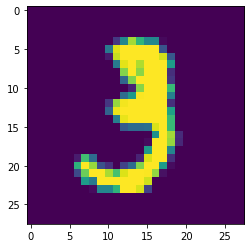

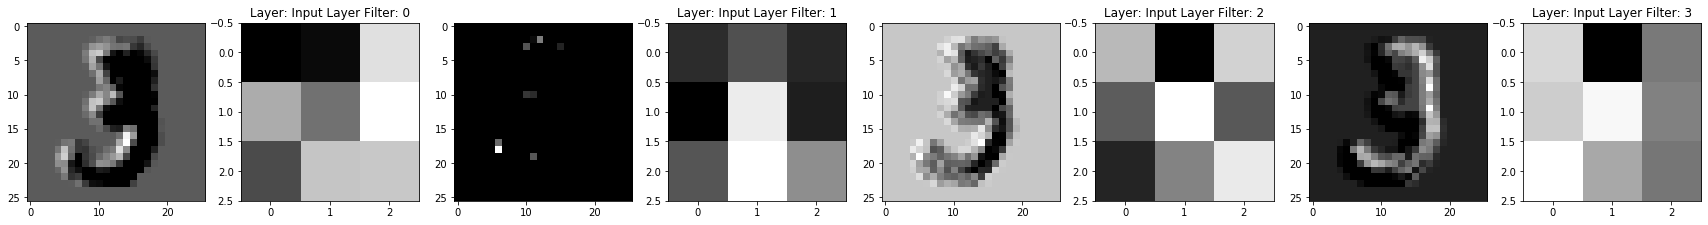

Pool2d1
Input



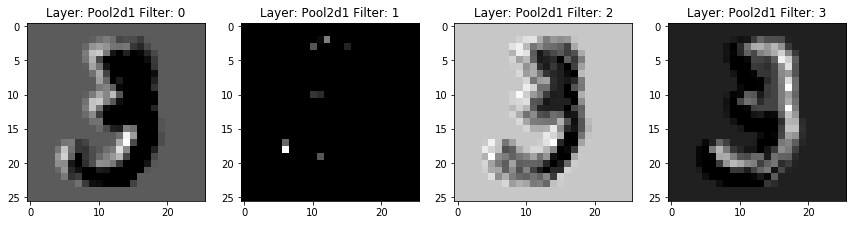

Output



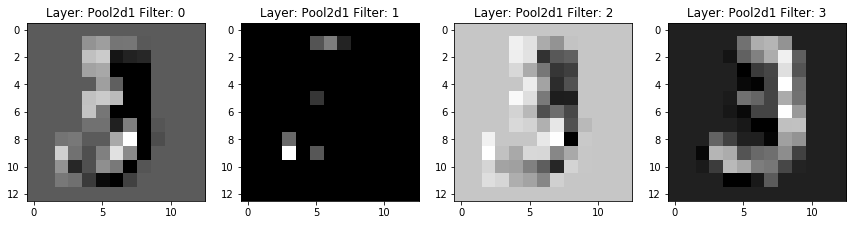

Conv2d2


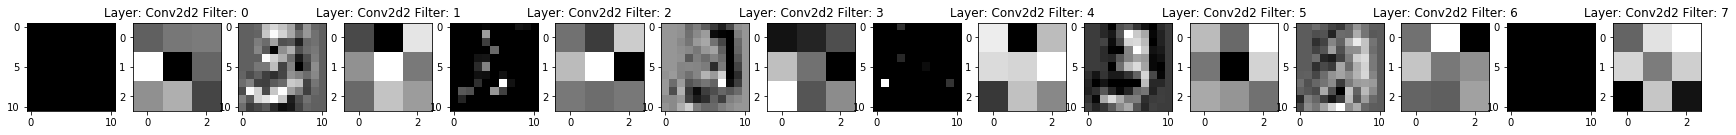

Dropout3
Input



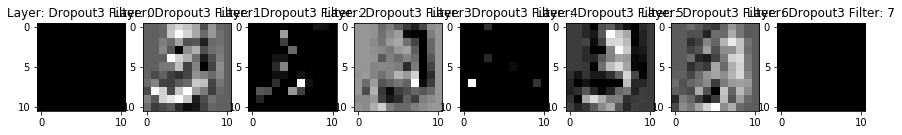

Output



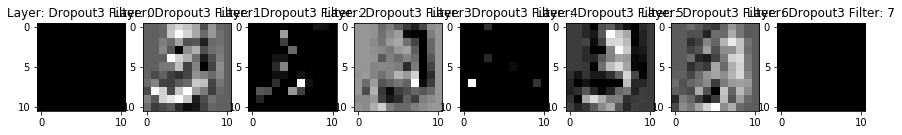

Flatten4
Out Layer(FFL)


In [75]:
timg = x[10]
plt.imshow(timg.reshape(28, 28))
op = mm.predict(timg)
for l in mm.layers:
    print(l.name)
    if type(l).__name__ == "Conv2d":
        fig = plt.figure(figsize=(30, 30))
        cols = l.filters * 2
        rows = 1
        f = 0
        for i in range(0, cols*rows):
            fig.add_subplot(rows, cols, i+1)                    
            if i % 2 == 0:
                if f < l.filters:
                    plt.imshow(l.out[:, :, f], cmap="gray")
                   
            else:
                if f < l.filters:
                    cimg = l.weights[:, :, 0, f]
                    plt.imshow(cimg, cmap='gray')
                    plt.title(f"Layer: {l.name} Filter: {f}")
                    f+=1                    
        #plt.show()
    if type(l).__name__ == "Pool2d":
        fig = plt.figure(figsize=(30, 30))
        cols = l.out.shape[2] * 2
        rows = 1
        print("Input\n")
        for f in range(l.out.shape[2]):
            fig.add_subplot(rows, cols, f+1)                    
            plt.imshow(l.input[:, :, f], cmap="gray")
            plt.title(f"Layer: {l.name} Filter: {f}")
        plt.show()
        fig = plt.figure(figsize=(30, 30))
        print("Output\n")
        for f in range(l.out.shape[2]):
            fig.add_subplot(rows, cols, f+1)                    
            plt.imshow(l.out[:, :, f], cmap="gray")
            plt.title(f"Layer: {l.name} Filter: {f}")
    if type(l).__name__ == "Dropout":
        try:
            fig = plt.figure(figsize=(30, 30))
            cols = l.out.shape[2] * 2
            rows = 1
            print("Input\n")
            for f in range(l.out.shape[2]):
                fig.add_subplot(rows, cols, f+1)                    
                plt.imshow(l.input[:, :, f], cmap="gray")
                plt.title(f"Layer: {l.name} Filter: {f}")
            plt.show()
            fig = plt.figure(figsize=(30, 30))
            print("Output\n")
            for f in range(l.out.shape[2]):
                fig.add_subplot(rows, cols, f+1)                    
                plt.imshow(l.out[:, :, f], cmap="gray")
                plt.title(f"Layer: {l.name} Filter: {f}")
        except:
            pass
    plt.show()
    

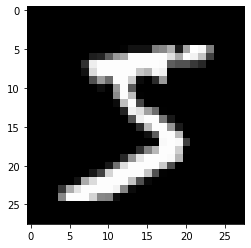

Input Layer


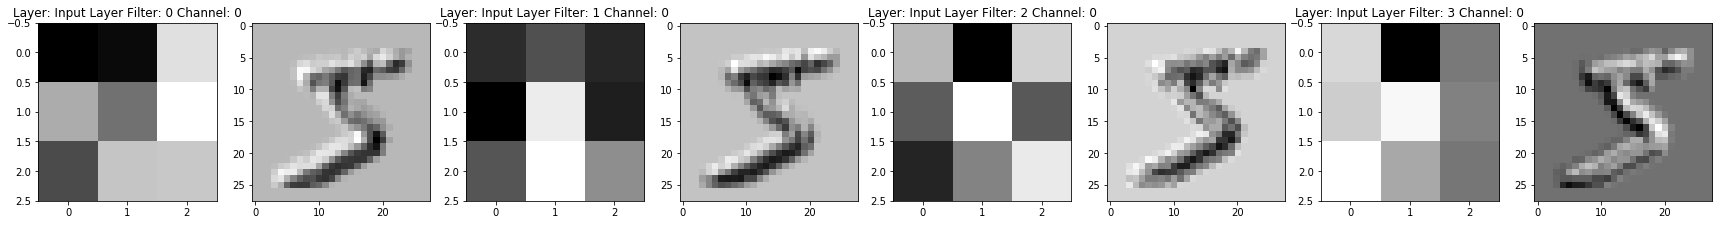

Conv2d2


<Figure size 2160x720 with 0 Axes>

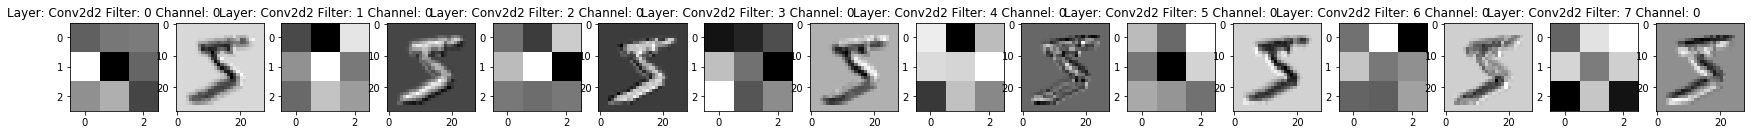

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

In [45]:
plt.imshow(timg.reshape(28, 28), cmap="gray")
plt.show()

for l in mm.layers:
    fig = plt.figure(figsize=(30, 10))
    if type(l).__name__ == "Conv2d":
        print(l.name)
        cols = l.filters * 2
        rows = 1
        f = 0
        for i in range(0, cols*rows):
            fig.add_subplot(rows, cols, i+1)                    
            if i %2 == 0:
                if f < l.filters:
                    plt.imshow(l.weights[:, :, c, f], cmap="gray")
                    plt.title(f"Layer: {l.name} Filter: {f} Channel: {c}")
            else:
                if f < l.filters:
                    cimg = cv2.filter2D(timg, -1, l.weights[:, :, 0, f])
                    plt.imshow(cimg, cmap='gray')
                    f+=1
                    
        plt.show()


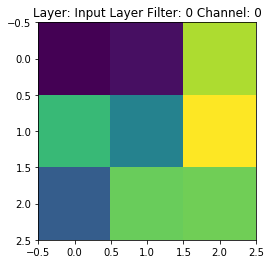

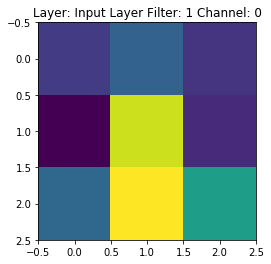

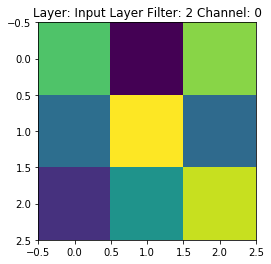

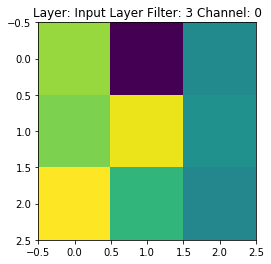

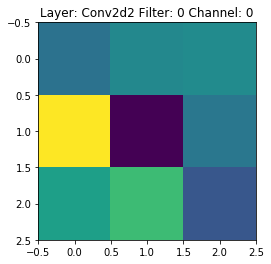

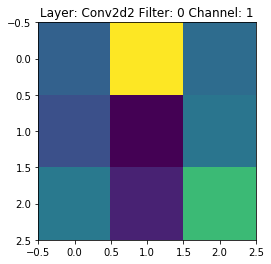

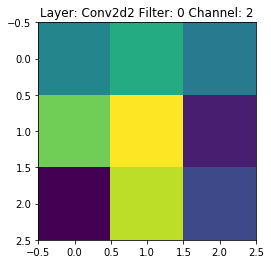

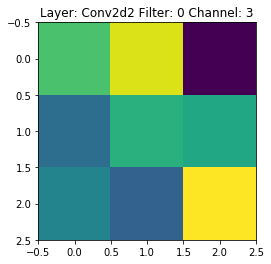

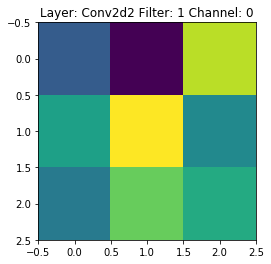

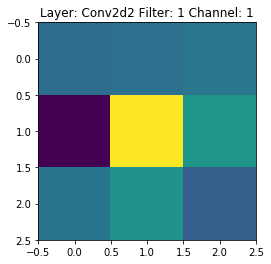

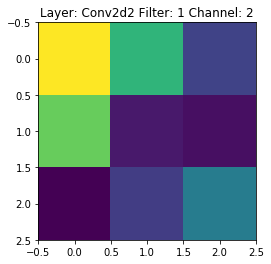

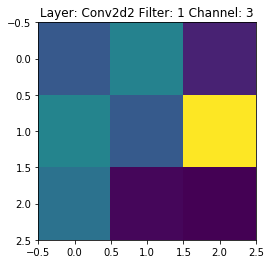

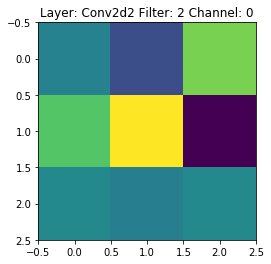

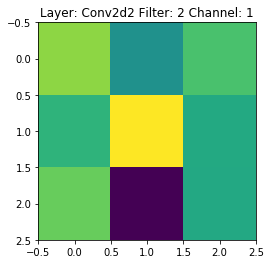

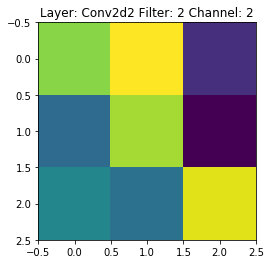

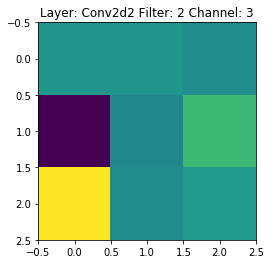

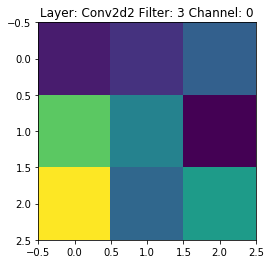

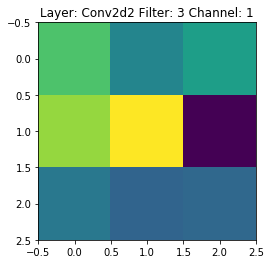

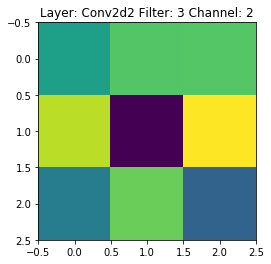

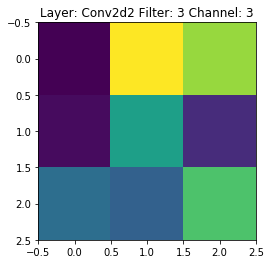

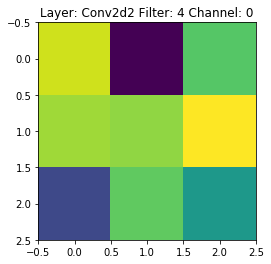

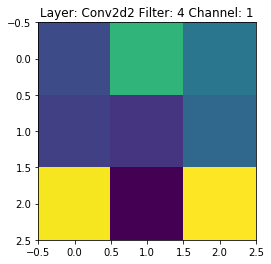

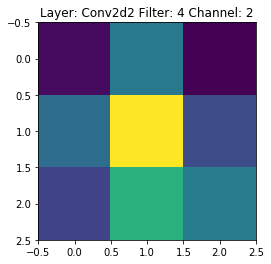

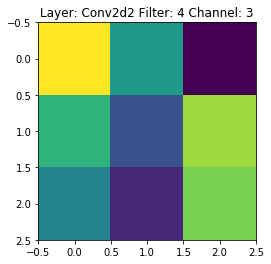

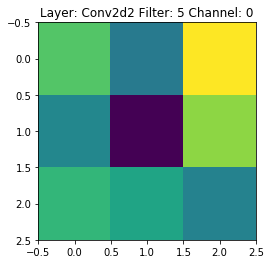

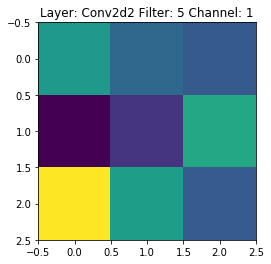

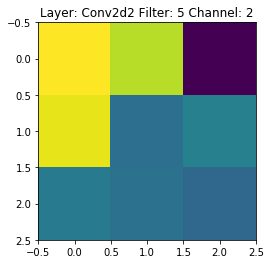

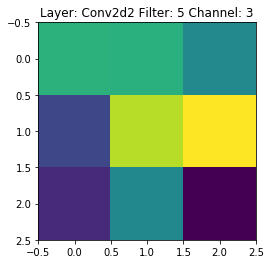

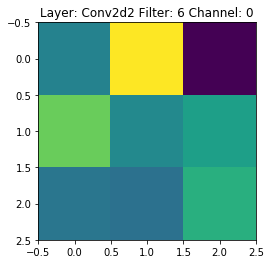

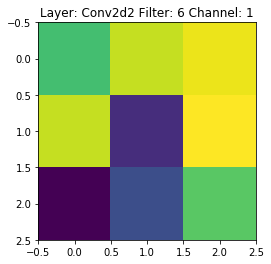

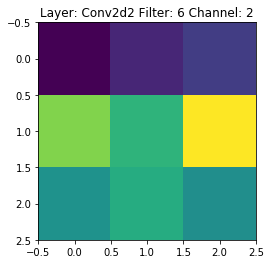

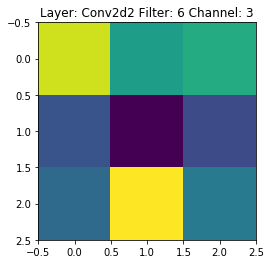

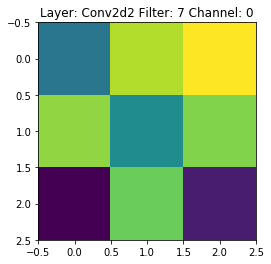

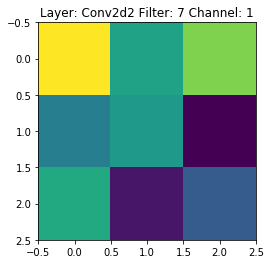

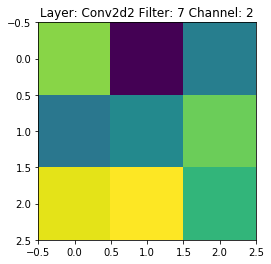

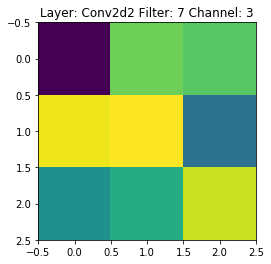

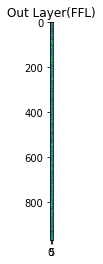

In [96]:
for l in mm.layers:
    if type(l).__name__ == "Conv2d":
        for f in range(l.filters):
            for c in range(l.weights.shape[2]):
                plt.imshow(l.weights[:, :, c, f])
                plt.title(f"Layer: {l.name} Filter: {f} Channel: {c}")
                plt.show()
    if type(l).__name__ == "FFL":
        plt.imshow(l.weights)
        plt.title(l.name)
        plt.show()

In [11]:
class Dropout:
    def __init__(self, prob = 0.5):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        self.prob = prob
        self.dw = 0
        self.db = 0
        
    def set_output_shape(self):
        #print(self.input_shape)
        self.output_shape = self.input_shape
        self.weights = 0
    def apply_activation(self, x):
        self.input_data = x
        #print(x.sum(axis=2))
        flat = np.array(self.input_data).flatten()
        random_indices = np.random.randint(0, len(flat), int(self.prob * len(flat)))
        flat[random_indices] = 0
        self.output = flat.reshape(x.shape)
        return self.output
    def activation_dfn(self, x):
        return x
           
x = np.arange(0, 100).reshape(10, 10)
dp = Dropout()
dp.apply_activation(x)

yy = np.arange(1, 11)
def one_hot_encoding(lbl, classes):
    encoded = np.zeros((len(lbl), classes))
    c = list(set(lbl))
    if len(c) != classes:
        raise ValueError("Number of classes is not equal to unique labels.")
    for i in range(len(yy)):
        for j in range(len(c)):
            if c[j] == lbl[i]:
                encoded[i, j] = 1
    return encoded
#yy = l.copy()
#c = len(set(l))
#ohe = one_hot_encoding(yy, c)      
#print(ohe[0])

class Pool2d:
    def __init__(self, kernel_size = (2, 2), stride=(1, 1), kind="max"):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        
        self.kernel_size = kernel_size
        if type(stride) == int:
                 stride = (stride, stride)

        self.stride = stride
        self.pools = ['max', "average", 'min']
        if kind not in self.pools:
            raise ValueError("Pool kind not understoood.")
            
        self.kind = kind
    
    def set_output_shape(self):
        shape = self.input_shape
        stride = self.stride
        kshape = self.kernel_size
        rstep = stride[0]+kshape[0]-1
        cstep = stride[1]+kshape[1]-1
        rv = rstep * len(range(kshape[0], shape[0]+1, rstep))
        cv = cstep * len(range(kshape[1], shape[1]+1, cstep))
        self.output_shape = (int(rv/rstep), int(cv/cstep), shape[2])
#         print(self.output_shape)
        self.weights = 0
    def apply_activation(self, image):
        stride = self.stride
        kshape = self.kernel_size
        shape = image.shape
        self.input_shape = shape
        self.set_output_shape()
        #print(self.output_shape, shape)
        
        
        rstep = stride[0]+kshape[0]-1
        cstep = stride[1]+kshape[1]-1
        self.out = np.zeros((self.output_shape))
        for nc in range(shape[2]):
            cimg = []
            rv = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    chunk = image[rv:r, cv:c, nc]
                    if len(chunk) > 0:
                        
                        if self.kind == "max":
                            #print(chunk)
                            chunk = np.max(chunk)
                        if self.kind == "min":
                            chunk = np.min(chunk)
                        if self.kind == "average":
                            chunk = np.mean(chunk)

                        cimg.append(chunk)
                    else:
                        cv-=cstep
                        #rv-=rstep
                    cv+=cstep
                rv+=rstep
            cimg = np.array(cimg).reshape(int(rv/rstep), int(cv/cstep))
            #print(cimg.shape)
            self.out[:,:,nc] = cimg
        return self.out
pool = Pool2d(kernel_size=(7, 7), kind="max")
test = np.random.randint(1, 100, (32, 32, 3))
o = pool.apply_activation(test)
o.shape

class Flatten:
    def __init__(self, input_shape=None):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        
    def set_output_shape(self):
        #print(self.input_shape)
        self.output_shape = (self.input_shape[0] * self.input_shape[1] * self.input_shape[2])
        self.weights = 0
    def apply_activation(self, x):
        self.input_data = x
        #print(x.sum(axis=2))
        self.output = np.array(self.input_data).flatten()
        return self.output
    def activation_dfn(self, x):
        return x
#x = np.array([[1, 1, 1], [1, 0, 1], [0, 1, 1], [0, 0, 1]])
#f = Flatten()
#f.apply_activation(test).shape


(3072,)

In [ ]:
yy = np.arange(1, 11)
def one_hot_encoding(lbl, classes):
    encoded = np.zeros((len(lbl), classes))
    c = list(set(lbl))
    if len(c) != classes:
        raise ValueError("Number of classes is not equal to unique labels.")
    for i in range(len(yy)):
        for j in range(len(c)):
            if c[j] == lbl[i]:
                encoded[i, j] = 1
    return encoded
yy = l.copy()
c = len(set(l))
ohe = one_hot_encoding(yy, c)      
print(ohe[0])

In [ ]:
class Pool2d:
    def __init__(self, kernel_size = (2, 2), stride=(1, 1), kind="max"):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        
        self.kernel_size = kernel_size
        if type(stride) == int:
                 stride = (stride, stride)

        self.stride = stride
        self.pools = ['max', "average", 'min']
        if kind not in self.pools:
            raise ValueError("Pool kind not understoood.")
            
        self.kind = kind
    
    def set_output_shape(self):
        shape = self.input_shape
        stride = self.stride
        kshape = self.kernel_size
        rstep = stride[0]+kshape[0]-1
        cstep = stride[1]+kshape[1]-1
        rv = rstep * len(range(kshape[0], shape[0]+1, rstep))
        cv = cstep * len(range(kshape[1], shape[1]+1, cstep))
        self.output_shape = (int(rv/rstep), int(cv/cstep), shape[2])
#         print(self.output_shape)
        self.weights = 0
    def apply_activation(self, image):
        stride = self.stride
        kshape = self.kernel_size
        shape = image.shape
        self.input_shape = shape
        self.set_output_shape()
        #print(self.output_shape, shape)
        
        
        rstep = stride[0]+kshape[0]-1
        cstep = stride[1]+kshape[1]-1
        self.out = np.zeros((self.output_shape))
        for nc in range(shape[2]):
            cimg = []
            rv = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    chunk = image[rv:r, cv:c, nc]
                    if len(chunk) > 0:
                        
                        if self.kind == "max":
                            #print(chunk)
                            chunk = np.max(chunk)
                        if self.kind == "min":
                            chunk = np.min(chunk)
                        if self.kind == "average":
                            chunk = np.mean(chunk)

                        cimg.append(chunk)
                    else:
                        cv-=cstep
                        #rv-=rstep
                    cv+=cstep
                rv+=rstep
            cimg = np.array(cimg).reshape(int(rv/rstep), int(cv/cstep))
            #print(cimg.shape)
            self.out[:,:,nc] = cimg
        return self.out
pool = Pool2d(kernel_size=(7, 7), kind="max")
test = np.random.randint(1, 100, (32, 32, 3))
o = pool.apply_activation(test)
o.shape

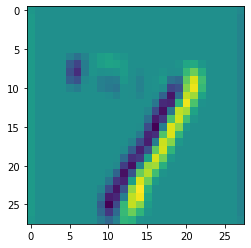

In [77]:
#img = np.random.randint(0, 255, (10, 10, 1))
img = xt[0]
conv = Conv2d()
conv.input=img
conv.weights = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]).reshape(3, 3, 1, 1)
conv.biases = np.zeros(1)
conv.out = np.zeros((28, 28, 1))
cout = conv.apply_activation(img)
plt.imshow(cout.reshape(28, 28))

In [ ]:
class Flatten:
    def __init__(self, input_shape=None):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        
    def set_output_shape(self):
        #print(self.input_shape)
        self.output_shape = (self.input_shape[0] * self.input_shape[1] * self.input_shape[2])
        self.weights = 0
    def apply_activation(self, x):
        self.input_data = x
        #print(x.sum(axis=2))
        self.output = np.array(self.input_data).flatten()
        return self.output
    def activation_dfn(self, x):
        return x
#x = np.array([[1, 1, 1], [1, 0, 1], [0, 1, 1], [0, 0, 1]])
f = Flatten()
f.apply_activation(test).shape

In [83]:
class Unsample:
    def __init__(self, kernel_size = (2, 2)):
        self.input_shape=None
        self.output_shape = None
        self.input_data= None
        self.output = None
        self.isbias = False
        self.activation = None
        self.parameters = 0
        self.delta = 0
        self.weights = 0
        self.bias = 0
        self.delta_weights = 0
        self.delta_biases = 0        
        self.kernel_size = kernel_size
        self.stride = self.kernel_size
        
    
    def set_output_shape(self):
        shape = self.input_shape
        self.output_shape = (shape[0] * self.kernel_size[0], shape[1] * self.kernel_size[1], shape[2])
        self.weights = 0
    def apply_activation(self, image):
        stride = self.stride
        kshape = self.kernel_size
        self.input_shape = image.shape
        self.set_output_shape()
        
        rstep = stride[0]
        cstep = stride[1]
        self.out = np.zeros(self.output_shape)
        shape = self.output_shape
        
        
        for nc in range(shape[2]):
            cimg = []
            rv = 0
            i = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    self.out[rv:r, cv:c] = image[i, j]
                    j+=1
                    cv+=cstep
                rv+=rstep
                i+=1
                
        return self.out
    def backpropagate(self, nx_layer):
        """
            Gradients are passed through index of largest value .
        """
        layer = self
        stride = layer.stride
        kshape = layer.kernel_size
        image = layer.input
        shape = image.shape
        layer.delta = np.zeros(shape)
        #self.input_shape = shape
        #self.set_output_shape()
        #print(self.output_shape)
        
        cimg = []
        rstep = stride[0]
        cstep = stride[1]
        
        for f in range(shape[2]):
            i = 0
            rv = 0
            for r in range(kshape[0], shape[0]+1, rstep):
                cv = 0
                j = 0
                for c in range(kshape[1], shape[1]+1, cstep):
                    chunk = image[rv:r, cv:c, f]
                    dout = nx_layer.delta[i, j, f]
                    
                    if layer.kind == "max":
                        p = np.max(chunk)
                        #print(p, chunk)
                        index = np.argwhere(chunk == p)[0]
                        #print(layer.delta[rv+index[0], cv+index[1], f].shape, dout.shape)
                        layer.delta[rv+index[0], cv+index[1], f] = dout
                        #print(index)
                    if layer.kind == "min":
                        p = np.min(chunk)
                        index = np.argwhere(chunk == p)[0]
                        layer.delta[rv+index[0], cv+index[1], f] = dout
                    if layer.kind == "average":
                        p = np.mean(chunk)
                        layer.delta[rv:r, cv:c, f] = dout


                    j+=1
                    cv+=cstep
                rv+=rstep
                i+=1

In [84]:
us = Unsample(kernel_size=(1, 3))
img = us.apply_activation(x_train[0].reshape(28, 28, 1))

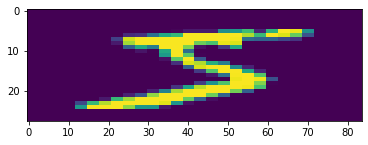

In [75]:
plt.imshow(img.reshape(28, 28*3))

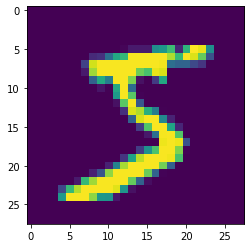

In [46]:
plt.imshow(x_train[0].reshape(28, 28))

In [49]:
img.max()

0.0

In [62]:
x_train[0].reshape(28, 28, 1).max()

255